In [42]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [43]:
class MaterialKNNClassifier:
    """KNN-based classifier for material stream identification."""
    
    def __init__(self, n_neighbors=5, weights='distance', metric='euclidean', rejection_threshold=0.6):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.rejection_threshold = rejection_threshold
        
        self.scaler = StandardScaler()
        self.knn = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            metric=metric,
            n_jobs=-1
        )
        
        self.classes = {
            0: "Glass", 1: "Paper", 2: "Cardboard",
            3: "Plastic", 4: "Metal", 5: "Trash", 6: "Unknown"
        }
    
    def train(self, X_train, y_train, X_test=None, y_test=None):
        print(f"Training KNN Classifier")
        print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        print("Performing hyperparameter tuning")
        best_params = self._grid_search(X_train_scaled, y_train)
        print(f"Best parameters found: {best_params}")
        
        train_pred = self.knn.predict(X_train_scaled)
        train_acc = accuracy_score(y_train, train_pred)
        
        results = {
            'train_accuracy': train_acc,
            'n_neighbors': self.n_neighbors,
            'weights': self.weights,
            'metric': self.metric
        }
        
        print(f"Training Accuracy: {train_acc:.4f}")
        
        if X_test is not None and y_test is not None:
            test_acc = self.evaluate(X_test, y_test)
            results['test_accuracy'] = test_acc
            print(f"Testing Accuracy: {test_acc:.4f}")
        
        return results
    
    def _grid_search(self, X_train, y_train):
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11, 15],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
        
        grid_search = GridSearchCV(
            KNeighborsClassifier(n_jobs=-1),
            param_grid, cv=5, scoring='accuracy',
            n_jobs=-1, verbose=2
        )
        
        grid_search.fit(X_train, y_train)
        
        self.n_neighbors = grid_search.best_params_['n_neighbors']
        self.weights = grid_search.best_params_['weights']
        self.metric = grid_search.best_params_['metric']
        self.knn = grid_search.best_estimator_
        
        return grid_search.best_params_
    
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        probabilities = self.knn.predict_proba(X_scaled)
        max_probs = np.max(probabilities, axis=1)
        predictions = self.knn.predict(X_scaled)
        predictions = np.where(max_probs < self.rejection_threshold, 6, predictions)
        return predictions
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return accuracy_score(y_test, y_pred)
    
    def save_model(self, filepath):
        model_data = {
            'knn': self.knn, 'scaler': self.scaler,
            'n_neighbors': self.n_neighbors, 'weights': self.weights,
            'metric': self.metric, 'rejection_threshold': self.rejection_threshold,
            'classes': self.classes
        }
        filepath = Path(filepath)
        filepath.parent.mkdir(parents=True, exist_ok=True)
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to: {filepath}")

## Load Features and Split Data

In [44]:
features_path = 'features/extracted_features.pkl'

with open(features_path, 'rb') as f:
    data = pickle.load(f)

X = data['features']
y = data['labels']

print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features each")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=53, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Loaded 3000 samples with 2048 features each
Training samples: 2400
Testing samples: 600


## Train KNN Classifier

In [65]:
classifier = MaterialKNNClassifier(
    n_neighbors=3,
    weights='distance',
    metric='manhattan',
    rejection_threshold=0.4
)

results = classifier.train(X_train, y_train, X_test, y_test)

Training KNN Classifier
Training samples: 2400, Features: 2048
Performing hyperparameter tuning
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Training Accuracy: 1.0000
Testing Accuracy: 0.9317


## Evaluate and Visualize Results

In [66]:
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Testing Accuracy: 0.9317

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       100
           1       0.96      0.91      0.93       100
           2       1.00      0.96      0.98       100
           3       0.98      0.88      0.93       100
           4       0.93      0.94      0.94       100
           5       0.94      1.00      0.97       100
           6       0.00      0.00      0.00         0

    accuracy                           0.93       600
   macro avg       0.81      0.80      0.81       600
weighted avg       0.95      0.93      0.94       600



C:\Users\z\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\z\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\z\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


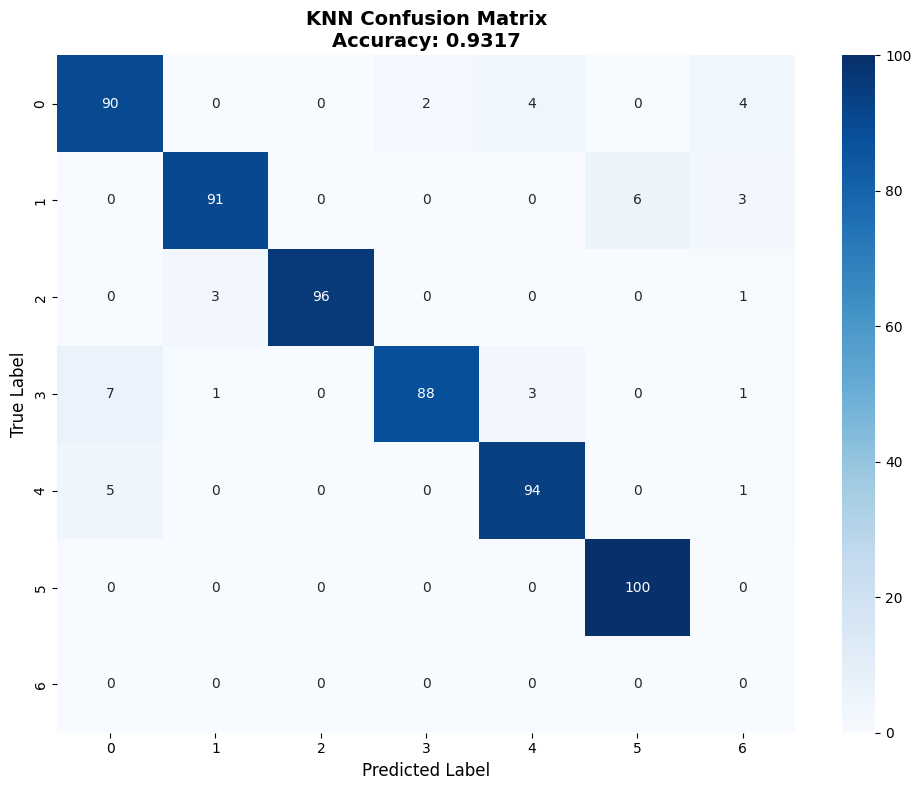


Best Configuration: k=3, weights=distance, metric=euclidean


In [67]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'KNN Confusion Matrix\nAccuracy: {accuracy:.4f}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nBest Configuration: k={classifier.n_neighbors}, weights={classifier.weights}, metric={classifier.metric}")

## Save Model

In [68]:
model_path = 'models/knn_final.pkl'
classifier.save_model(model_path)

Model saved to: models\knn_final.pkl
